### CLDS Algoritmi: Greedy, VNS i Hybrid
Ova sveska implementira različite algoritme za pronalaženje najduže podsekvence u stringu koja:
- Pokriva sva slova iz alfabeta barem jednom.
- Pojavljuje se bar 2 puta u originalnom stringu kao subsequence.
- Svaka pozicija u originalnom stringu može se koristiti samo jednom po pojavljivanju.

In [13]:
# Uvoz potrebnih biblioteka
import os
import pandas as pd
import random
from itertools import permutations
import matplotlib.pyplot as plt

#### Brojanje nepreklapajućih pojavljivanja
Funkcija `count_nonoverlapping_occurrences` računa koliko puta se podsekvenca pojavljuje u stringu, tako da se svaki karakter koristi samo jednom po pojavljivanju.

In [14]:
def count_nonoverlapping_occurrences(sub, s):
    if not sub:
        return 0
    used = [False] * len(s)
    count = 0
    while True:
        i_sub = 0
        for i_s, c in enumerate(s):
            if i_sub >= len(sub):
                break
            if not used[i_s] and c == sub[i_sub]:
                i_sub += 1
                used[i_s] = True
        if i_sub < len(sub):
            break
        count += 1
    return count

#### Fitness funkcija
Funkcija `clds_fitness` vraća broj nepreklapajućih pojavljivanja podsekvence samo ako podsekvenca sadrži sva slova iz alfabeta.

In [15]:
def clds_fitness(sub, s, alphabet, d):
    # svaki simbol iz alfabetu mora biti prisutan, i max d po simbolu
    if not all(c in sub for c in alphabet):
        return 0
    if any(sub.count(c) > d for c in alphabet):
        return 0
    return count_nonoverlapping_occurrences(sub, s)

#### Greedy Basic (poboljšan)
Pokušava da pronađe minimalni komplet permutacija alfabeta i blago ga proširuje karakterom koji se najčešće pojavljuje. Cilj je da algoritam pronađe što bolju podsekvencu, ali ne preuzima sve što Advanced radi.

In [16]:
def greedy_basic(s, alphabet, d):
    counts = {c: s.count(c) for c in alphabet}
    min_complete = min(*counts.values(), d)
    if min_complete == 0:
        return "", 0

    best_sub = ""
    max_count = 0

    for perm in permutations(alphabet):
        candidate = ''.join(perm) * min_complete
        count = clds_fitness(candidate, s, alphabet, d)
        if count >= 2 and count > max_count:
            best_sub = candidate
            max_count = count

    if best_sub:
        most_common_char = max(counts, key=counts.get)
        extended = best_sub + most_common_char
        if clds_fitness(extended, s, alphabet, d) >= 2:
            best_sub = extended
            max_count = clds_fitness(extended, s, alphabet, d)

    return best_sub, max_count

#### Greedy Advanced
Probava sve permutacije i duže substringove kako bi pronašao najdužu moguću podsekvencu.

In [17]:
def greedy_advanced(s, alphabet, d):
    n = len(s)
    best_sub = ""
    max_count = 0
    max_len = 0

    counts = {c: s.count(c) for c in alphabet}
    min_complete = min(*counts.values(), d)

    for k in range(min_complete, 0, -1):
        for perm in permutations(alphabet):
            candidate = ''.join(perm) * k
            count = clds_fitness(candidate, s, alphabet, d)
            if count >= 2:
                if len(candidate) > max_len or (len(candidate) == max_len and count > max_count):
                    best_sub = candidate
                    max_len = len(candidate)
                    max_count = count
        if best_sub:
            return best_sub, max_count

    for length in range(len(alphabet), n + 1):
        for start in range(n - length + 1):
            sub = s[start:start+length]
            if all(c in sub for c in alphabet):
                count = clds_fitness(sub, s, alphabet, d)
                if count >= 2 and (length > max_len or (length == max_len and count > max_count)):
                    best_sub = sub
                    max_len = length
                    max_count = count
    return best_sub, max_count


#### VNS Basic (poboljšan)
Randomizovana pretraga oko početnog rešenja (od Greedy Basic) sa dodavanjem i uklanjanjem blokova.

In [18]:
def vns_basic(s, initial_solution, alphabet, d, max_iter=100):
    current, _ = initial_solution
    best = current
    best_count = clds_fitness(best, s, alphabet, d)

    for _ in range(max_iter):
        neighbor = list(best)

        if len(neighbor) + len(alphabet) <= len(s) and random.random() < 0.5:
            neighbor.extend(alphabet)

        if len(neighbor) >= 2 * len(alphabet) and random.random() < 0.3:
            neighbor = neighbor[:-len(alphabet)]

        if neighbor:
            pos = random.randint(0, len(neighbor)-1)
            neighbor[pos] = random.choice(alphabet)

        neighbor_str = ''.join(neighbor)
        count = clds_fitness(neighbor_str, s, alphabet, d)
        if count >= 2 and (count > best_count or len(neighbor_str) > len(best)):
            best = neighbor_str
            best_count = count

    return best, best_count

#### VNS Advanced
Naprednija varijanta VNS-a koja koristi i dodavanje/uklanjanje blokova i poboljšanu selekciju suseda.

In [19]:
def vns_advanced(s, initial_solution, alphabet, d, max_iter=500):
    current, current_count = initial_solution
    best = current
    best_count = current_count

    for _ in range(max_iter):
        neighbor = list(best)
        if len(neighbor) + len(alphabet) <= len(s):
            neighbor.extend(alphabet)
        if len(neighbor) >= 2 * len(alphabet) and random.random() < 0.4:
            neighbor = neighbor[:-len(alphabet)]
        if neighbor:
            pos = random.randint(0, len(neighbor)-1)
            neighbor[pos] = random.choice(alphabet)

        neighbor_str = ''.join(neighbor)
        count = clds_fitness(neighbor_str, s, alphabet, d)
        if count > best_count or (count == best_count and len(neighbor_str) > len(best)):
            best = neighbor_str
            best_count = count

    return best, best_count

#### Hybrid Advanced
Kombinacija Greedy Advanced i VNS Advanced.

In [20]:
def hybrid_advanced(s, alphabet, d):
    gb_adv_sub, gb_adv_count = greedy_advanced(s, alphabet, d)
    vb_adv_sub, vb_adv_count = vns_advanced(s, (gb_adv_sub, gb_adv_count), alphabet, d)
    return gb_adv_sub, gb_adv_count, vb_adv_sub, vb_adv_count

#### Upoređivanje algoritama
Prikaz rezultata svih algoritama po instancama.

In [21]:
def compare_algorithms(instances, alphabets, d):
    results = []
    for name, s in instances.items():
        alphabet = alphabets[name] if isinstance(alphabets, dict) else alphabets

        gb_sub, gb_count = greedy_basic(s, alphabet, d)
        ga_sub, ga_count = greedy_advanced(s, alphabet, d)
        vb_sub, vb_count = vns_basic(s, (gb_sub, gb_count), alphabet, d)
        va_sub, va_count = vns_advanced(s, (ga_sub, ga_count), alphabet, d)
        hy_sub, hy_count, hy_vb_sub, hy_vb_count = hybrid_advanced(s, alphabet, d)

        results.append({
            "Instance": name,
            "Greedy Basic": f"{gb_sub} ({gb_count})" if gb_count >= 2 else "",
            "Greedy Advanced": f"{ga_sub} ({ga_count})" if ga_count >= 2 else "",
            "VNS Basic": f"{vb_sub} ({vb_count})" if vb_count >= 2 else "",
            "VNS Advanced": f"{va_sub} ({va_count})" if va_count >= 2 else "",
            "Hybrid Advanced": f"{hy_vb_sub} ({hy_vb_count})" if hy_vb_count >= 2 else ""
        })
    return pd.DataFrame(results)

#### Test primeri za d = 1

In [22]:
# #### Pokretanje test primera sa ograničenjem d

# Definisanje instanci i alfabeta
instances_more = {
    "test1": "AABDBDD",
    "test2": "ABABABAB",
    "test3": "ACBDACBD",
    "test4": "AAAABBBBCCCCDDD",
    "test5": "ABDCABDCABDC",
    "test6": "AAAABBBBCCCCDDDABCD",
}
alphabets_more = {
    "test1": "ABD",
    "test2": "AB",
    "test3": "ABCD",
    "test4": "ABCD",
    "test5": "ABCD",
    "test6": "ABCD"
}

# Ograničenje d po simbolu
d = 1

# Pokretanje algoritama na ovim primerima
df_results = compare_algorithms(instances_more, alphabets_more, d=d)

# Prikaz rezultata
df_results


,Instance,Greedy Basic,Greedy Advanced,VNS Basic,VNS Advanced,Hybrid Advanced
0,test1,ABD (2),ABD (2),ABD (2),ABD (2),ABD (2)
1,test2,AB (4),AB (4),AB (4),AB (4),AB (4)
2,test3,ACBD (2),ACBD (2),ACBD (2),ACBD (2),ACBD (2)
3,test4,ABCD (3),ABCD (3),ABCD (3),ABCD (3),ABCD (3)
4,test5,ABDC (3),ABDC (3),ABDC (3),ABDC (3),ABDC (3)
5,test6,ABCD (4),ABCD (4),ABCD (4),ABCD (4),ABCD (4)


#### Test primeri za d = 2

#### CLDS Algoritmi za DNK sekvence
Ova sveska učitava DNK sekvence iz `data` foldera i upoređuje performanse algoritama nad instancama koristeći alfabet `"ACGT"`.

#### Učitavanje instanci iz `data` foldera i automatski izbor d
Svaki fajl u folderu predstavlja jednu DNK sekvencu.

In [23]:
data_folder = "data"
instances_data = {}

for filename in os.listdir(data_folder):
    if filename.endswith(".txt"):
        path = os.path.join(data_folder, filename)
        with open(path, "r") as f:
            sequence = f.read().strip().upper()
            instances_data[filename] = sequence

# DNK alfabet
alphabet_dna = "ACGT"

# Automatski odredi d = minimalni broj pojavljivanja simbola u stringu
d_values = {}
for name, seq in instances_data.items():
    counts = [seq.count(c) for c in alphabet_dna]
    d_values[name] = min(counts)  # tako da ne prelazi broj pojavljivanja


#### Pokretanje CLDS algoritama i snimanje rezultata u CSV
Koristimo prethodno definisane funkcije (`greedy_basic`, `greedy_advanced`, `vns_basic`, `vns_advanced`, `hybrid_advanced`) nad DNK instancama.

In [24]:
results_list = []
for name in instances_data.keys():
    df_temp = compare_algorithms(
        {name: instances_data[name]},
        {name: alphabet_dna},
        d=d_values[name]
    )
    results_list.append(df_temp)

df_all_custom_d = pd.concat(results_list, ignore_index=True)

# Snimanje u CSV
df_all_custom_d.to_csv("results.csv", index=False)
print("Rezultati su sačuvani u 'results.csv'")

Rezultati su sačuvani u 'results.csv'


#### Prikaz rezultata u Markdown tabeli

In [25]:
'''for idx, row in df_all_custom_d.iterrows():
    print(f"#### Instanca: {row['Instance']}")
    print(f"| Algoritam | Subsekvenca (broj ponavljanja) |")
    print(f"|-----------|-------------------------------|")
    for alg in ["Greedy Basic", "Greedy Advanced", "VNS Basic", "VNS Advanced", "Hybrid Advanced"]:
        print(f"| {alg} | {row[alg]} |")
    print("\n")'''

'for idx, row in df_all_custom_d.iterrows():\n    print(f"#### Instanca: {row[\'Instance\']}")\n    print(f"| Algoritam | Subsekvenca (broj ponavljanja) |")\n    print(f"|-----------|-------------------------------|")\n    for alg in ["Greedy Basic", "Greedy Advanced", "VNS Basic", "VNS Advanced", "Hybrid Advanced"]:\n        print(f"| {alg} | {row[alg]} |")\n    print("\n")'

#### Vizuelna analiza
Prikaz broja pojavljivanja najbolje podsekvence po algoritmu i instanci.


Prosečan score za large instance:
VNS Advanced_score       558.2
Hybrid Advanced_score    557.3
Greedy Advanced_score    549.3
VNS Basic_score           96.2
Greedy Basic_score         0.0
dtype: float64


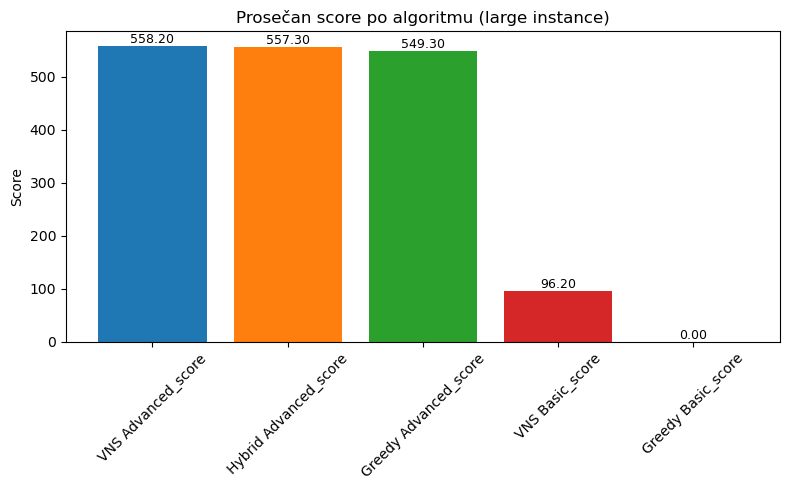


Prosečan score za medium instance:
VNS Advanced_score       119.7
Hybrid Advanced_score    119.7
Greedy Advanced_score    113.8
VNS Basic_score           90.5
Greedy Basic_score         0.0
dtype: float64


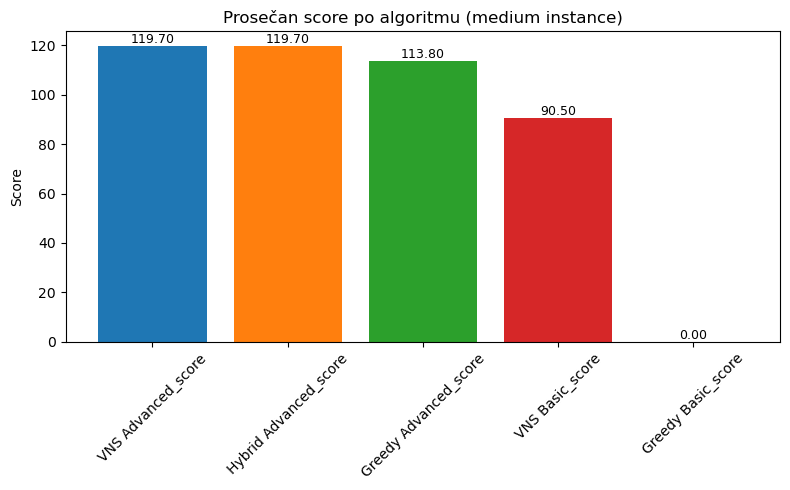


Prosečan score za small instance:
VNS Advanced_score       22.7875
Hybrid Advanced_score    22.5000
Greedy Advanced_score    20.9375
VNS Basic_score          19.5125
Greedy Basic_score        0.0000
dtype: float64


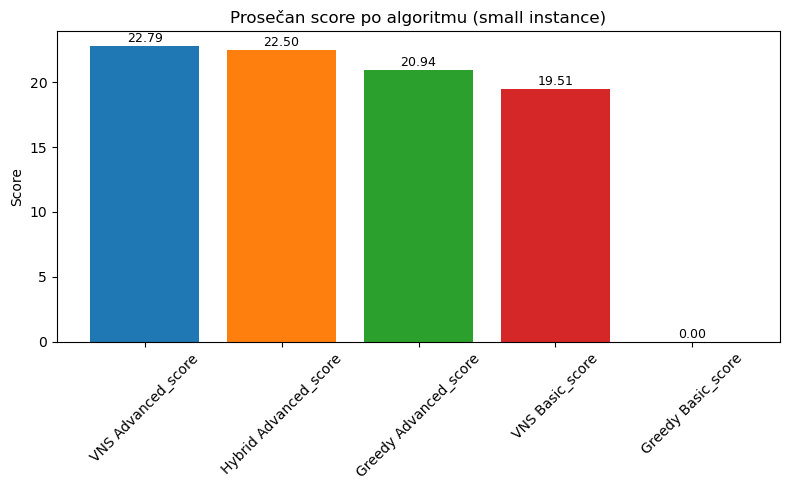


Prosečan score za xlarge instance:
VNS Advanced_score       1815.5000
Hybrid Advanced_score    1815.3000
Greedy Advanced_score    1804.7000
VNS Basic_score           140.7375
Greedy Basic_score          0.0000
dtype: float64


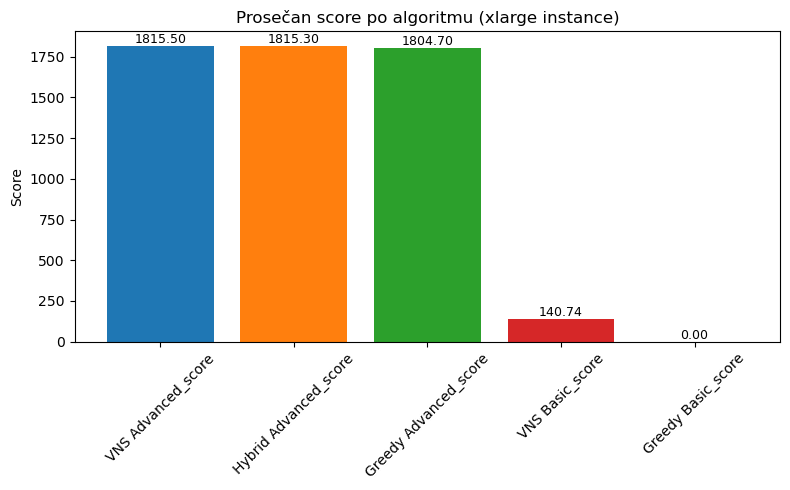

In [26]:
import pandas as pd
import re
import matplotlib.pyplot as plt

# --- Učitaj CSV ---
df = pd.read_csv("results.csv")

algorithms = ["Greedy Basic", "Greedy Advanced", "VNS Basic", "VNS Advanced", "Hybrid Advanced"]

# --- Funkcija za računanje score-a (duže sekvence nagrađuju više) ---
def effective_score(s):
    if pd.isna(s) or s.strip() == "":
        return 0
    match = re.match(r"(.*)\((\d+)\)", s.strip())
    if match:
        subseq, count = match.groups()
        subseq = subseq.strip()
        length = len(subseq)
        count = int(count)
        # nova logika: duže sekvence imaju veći score
        return length + 0.5 * count
    else:
        length = len(s.strip())
        return length + 0.5 * 1  # ako nema eksplicitnog ponavljanja, count=1

# --- Dodaj score kolone ---
for alg in algorithms:
    df[alg + "_score"] = df[alg].apply(effective_score)

# --- Odredi najbolji algoritam po instanci ---
def best_algorithm(row):
    best_val = -1
    best_alg = ""
    for alg in algorithms:
        val = row[alg + "_score"]
        if val > best_val:
            best_val = val
            best_alg = alg
    return best_alg

df["Best Algorithm"] = df.apply(best_algorithm, axis=1)

# --- Detektuj veličinu instance ---
def get_size(instance_name):
    if "small" in instance_name.lower():
        return "small"
    elif "medium" in instance_name.lower():
        return "medium"
    elif "large" in instance_name.lower() and "xlarge" not in instance_name.lower():
        return "large"
    elif "xlarge" in instance_name.lower():
        return "xlarge"
    else:
        return "unknown"

df["Size"] = df["Instance"].apply(get_size)

# --- Summary i bar chart po veličini ---
summary_tables = {}
for size in df["Size"].unique():
    subset = df[df["Size"] == size]
    summary = subset[[alg + "_score" for alg in algorithms]].mean().sort_values(ascending=False)
    summary_tables[size] = summary
    
    print(f"\nProsečan score za {size} instance:")
    print(summary)
    
    # Bar chart za tu veličinu
    plt.figure(figsize=(8,5))
    bars = plt.bar(summary.index, summary.values, color=plt.cm.tab10.colors[:len(summary)])
    plt.title(f"Prosečan score po algoritmu ({size} instance)")
    plt.ylabel("Score")
    plt.xticks(rotation=45)
    
    # Dodaj vrednosti iznad barova
    for i, val in enumerate(summary.values):
        plt.text(i, val + 0.05, f"{val:.2f}", ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()


In [30]:
import pandas as pd

# Učitaj CSV
df = pd.read_csv('results.csv')

# Pretvori dataframe iz sekvenci u dužine (score)
df_score = df.copy()
for col in df_score.columns[1:]:  # preskoči 'Instance'
    df_score[col] = df_score[col].fillna("").apply(len)  # dužina sekvence ili 0 ako prazno

# Mapiranje veličina
velicine_map = {
    'small': 'male',
    'medium': 'srednje',
    'large': 'velike',
    'xlarge': 'vrlo velike'
}

algoritmi = df_score.columns[1:].tolist()

# Ispis po veličinama
for vel_key, vel_name in velicine_map.items():
    print(f"\nRezultati po instancama za {vel_name} instance:\n")
    
    # Filtriraj dataframe po veličini
    df_vel = df_score[df_score['Instance'].str.contains(f'instance_{vel_key}_')]
    
    # Lista instanci
    inst_list = sorted(df_vel['Instance'].unique())
    
    # Zaglavlje tabele
    header = ['Algoritam'] + inst_list + ['Prosečan score']
    print("{:<20}".format(header[0]), end="")
    for h in header[1:]:
        print("{:>15}".format(h), end="")
    print()
    
    # Ispis po algoritmu
    for alg in algoritmi:
        scores = []
        for inst in inst_list:
            score = df_vel[df_vel['Instance'] == inst][alg].values
            scores.append(score[0] if len(score) > 0 else 0)
        avg_score = sum(scores)/len(scores)
        
        print("{:<20}".format(alg), end="")
        for s in scores:
            print("{:>15}".format(s), end="")
        print("{:>15.2f}".format(avg_score))



Rezultati po instancama za male instance:

Algoritam           instance_small_10_mixed.txtinstance_small_10_multiple_duplicates.txtinstance_small_10_one_duplicate.txtinstance_small_10_random.txtinstance_small_1_mixed.txtinstance_small_1_multiple_duplicates.txtinstance_small_1_one_duplicate.txtinstance_small_1_random.txtinstance_small_2_mixed.txtinstance_small_2_multiple_duplicates.txtinstance_small_2_one_duplicate.txtinstance_small_2_random.txtinstance_small_3_mixed.txtinstance_small_3_multiple_duplicates.txtinstance_small_3_one_duplicate.txtinstance_small_3_random.txtinstance_small_4_mixed.txtinstance_small_4_multiple_duplicates.txtinstance_small_4_one_duplicate.txtinstance_small_4_random.txtinstance_small_5_mixed.txtinstance_small_5_multiple_duplicates.txtinstance_small_5_one_duplicate.txtinstance_small_5_random.txtinstance_small_6_mixed.txtinstance_small_6_multiple_duplicates.txtinstance_small_6_one_duplicate.txtinstance_small_6_random.txtinstance_small_7_mixed.txtinstance_small_7_

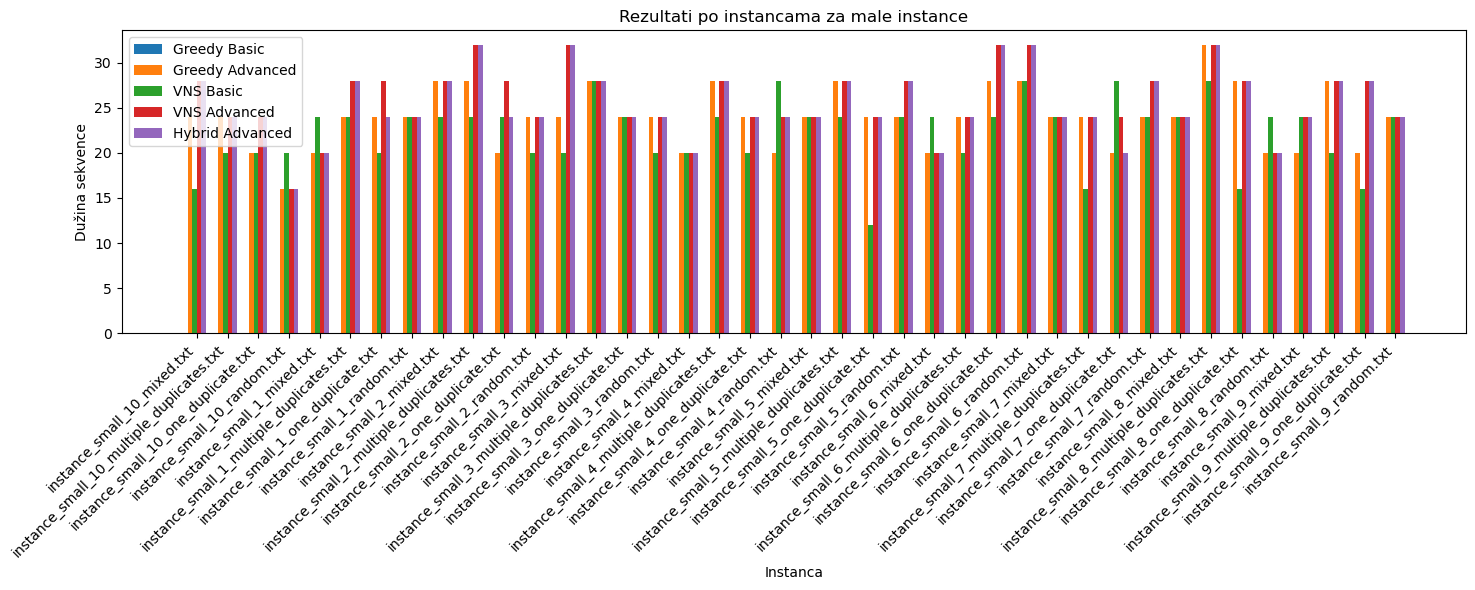

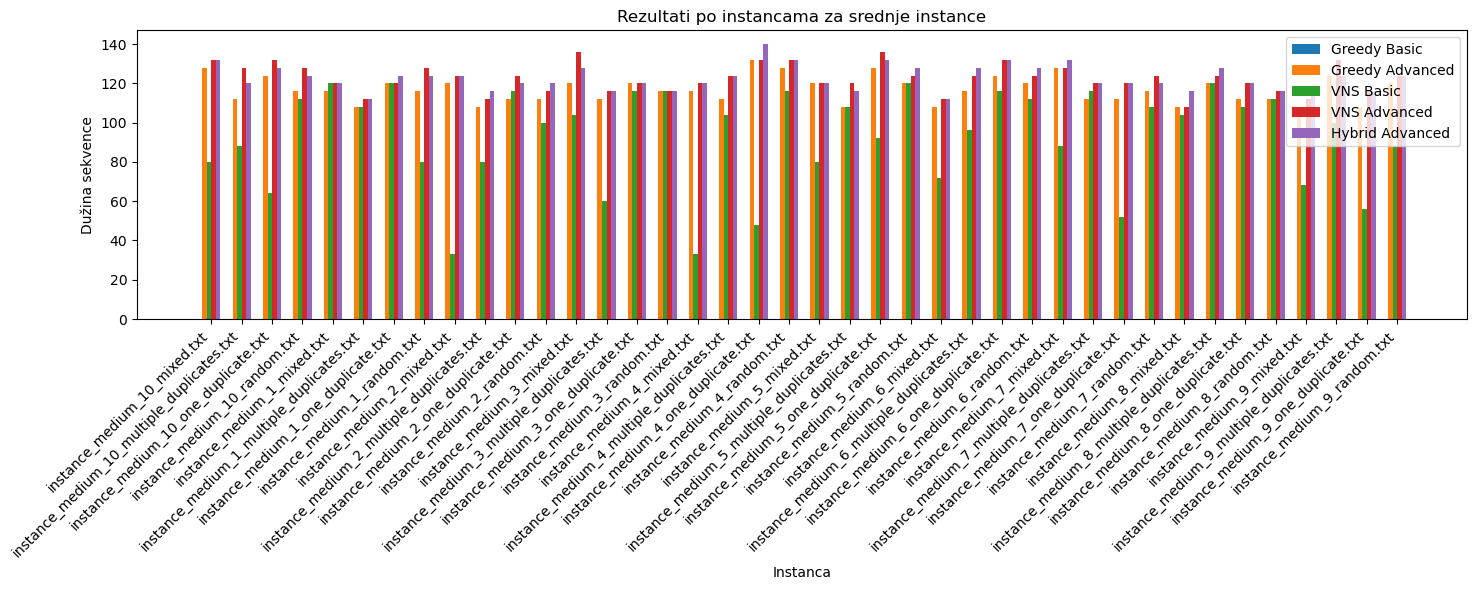

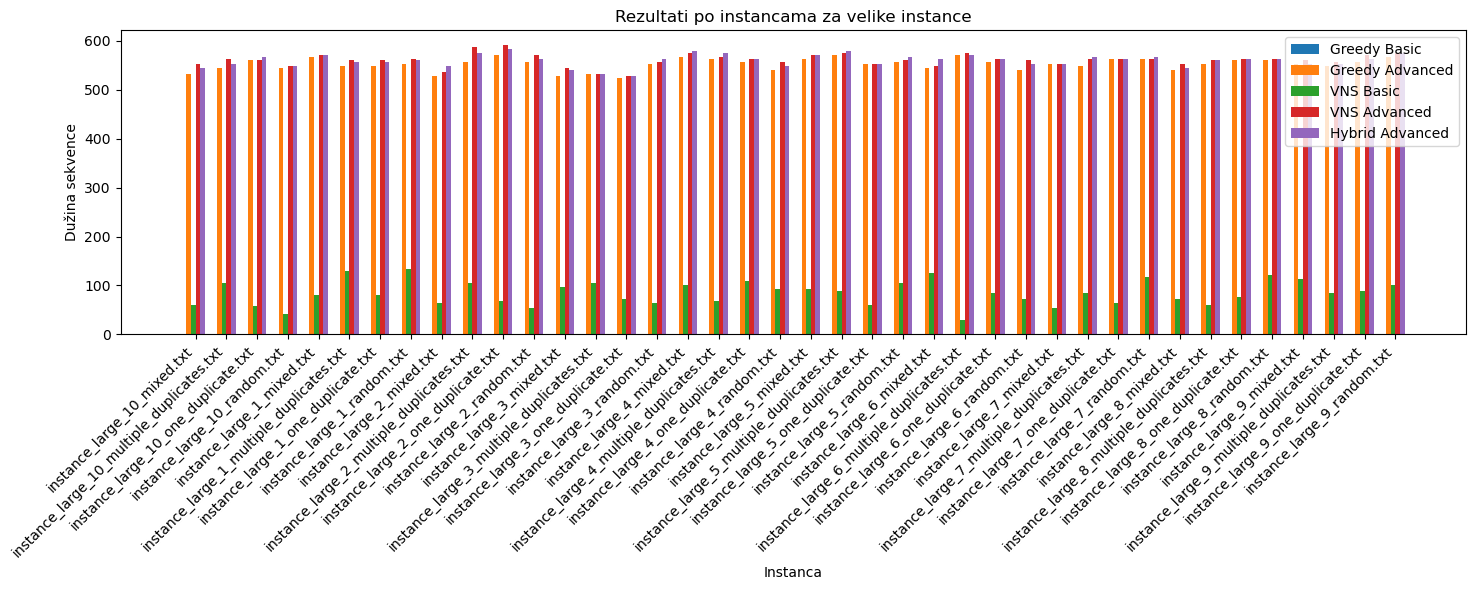

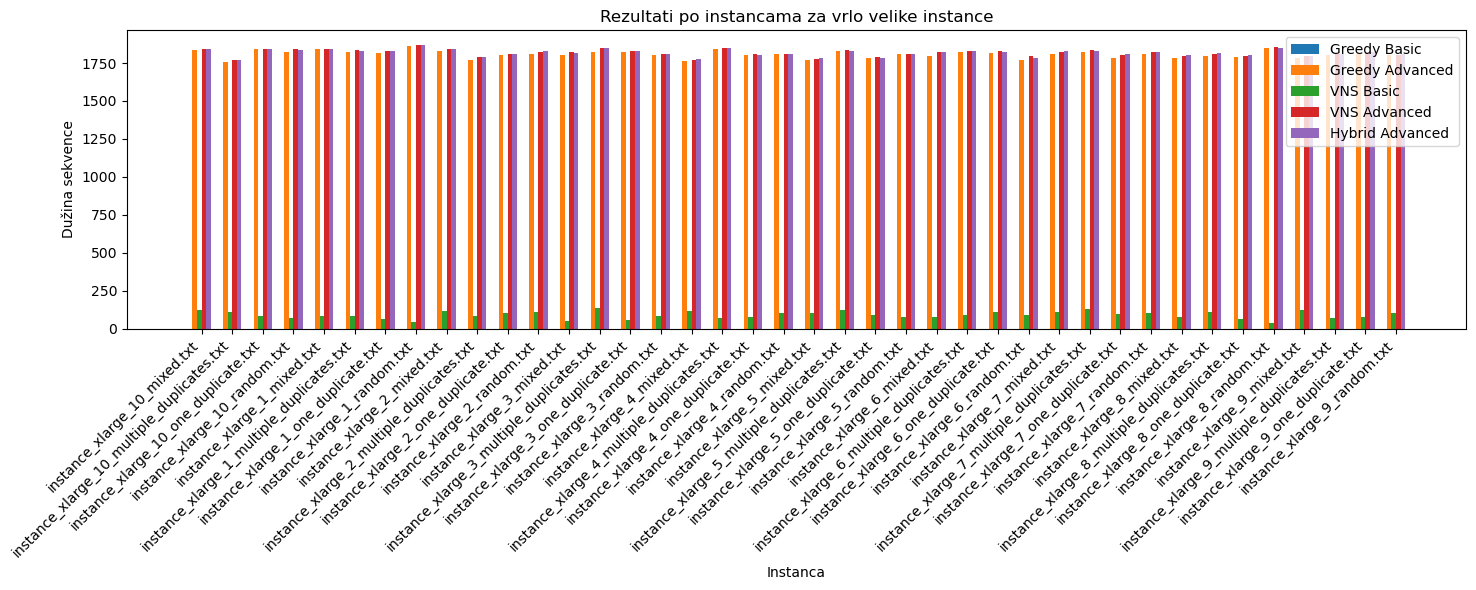

In [37]:
import matplotlib.pyplot as plt
import pandas as pd

# Učitaj CSV i konvertuj u score (dužina sekvence)
df = pd.read_csv('results.csv')
df_score = df.copy()
for col in df_score.columns[1:]:
    df_score[col] = df_score[col].fillna("").apply(len)

# Mapiranje veličina
velicine_map = {
    'small': 'male',
    'medium': 'srednje',
    'large': 'velike',
    'xlarge': 'vrlo velike'
}

algoritmi = df_score.columns[1:].tolist()

# Funkcija za crtanje stubičastog grafa
def plot_bar_scores(df_score, vel_key, vel_name):
    df_vel = df_score[df_score['Instance'].str.contains(f'instance_{vel_key}_')]
    inst_list = sorted(df_vel['Instance'].unique())
    
    plt.figure(figsize=(15,6))
    bar_width = 0.15
    x = range(len(inst_list))
    
    for i, alg in enumerate(algoritmi):
        scores = [df_vel[df_vel['Instance'] == inst][alg].values[0] for inst in inst_list]
        plt.bar([xi + i*bar_width for xi in x], scores, width=bar_width, label=alg)
    
    plt.xticks([xi + bar_width*(len(algoritmi)/2) for xi in x], inst_list, rotation=45, ha='right')
    plt.xlabel('Instanca')
    plt.ylabel('Dužina sekvence')
    plt.title(f'Rezultati po instancama za {vel_name} instance')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Crtanje za sve veličine
for vel_key, vel_name in velicine_map.items():
    plot_bar_scores(df_score, vel_key, vel_name)


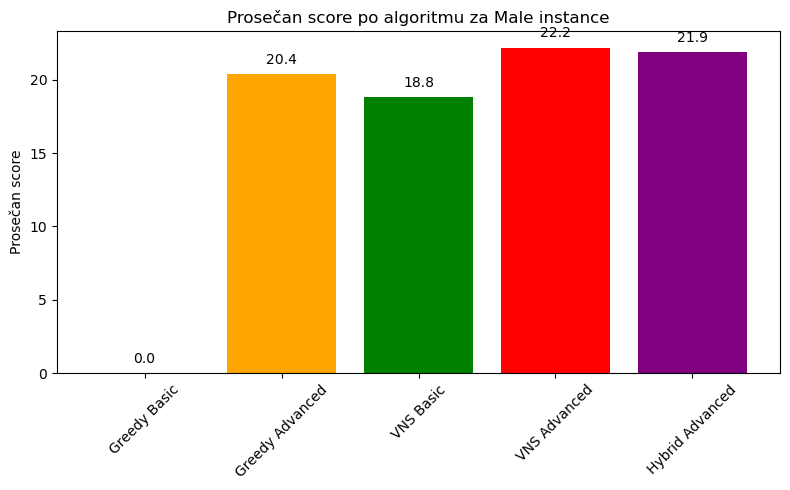

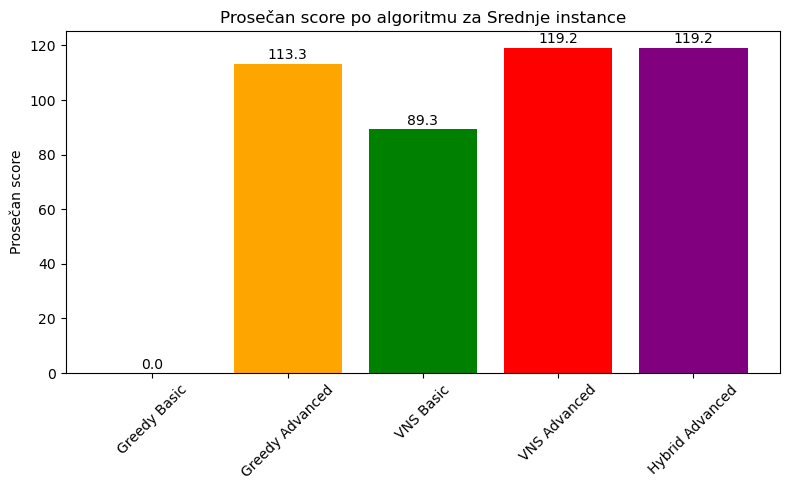

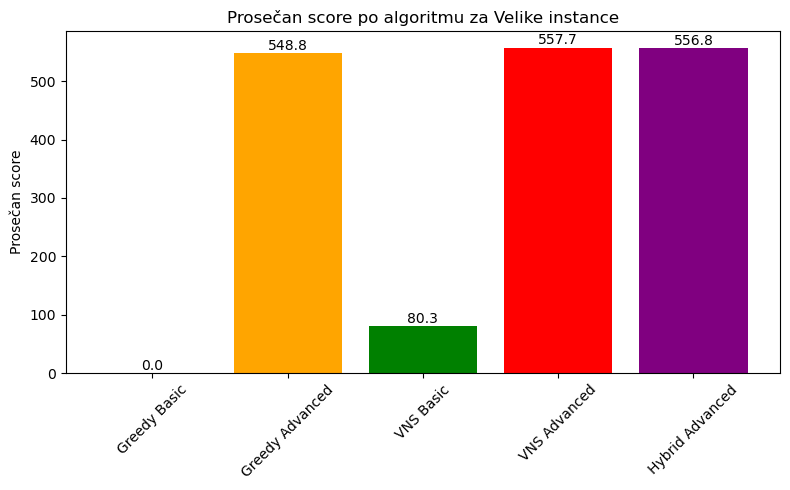

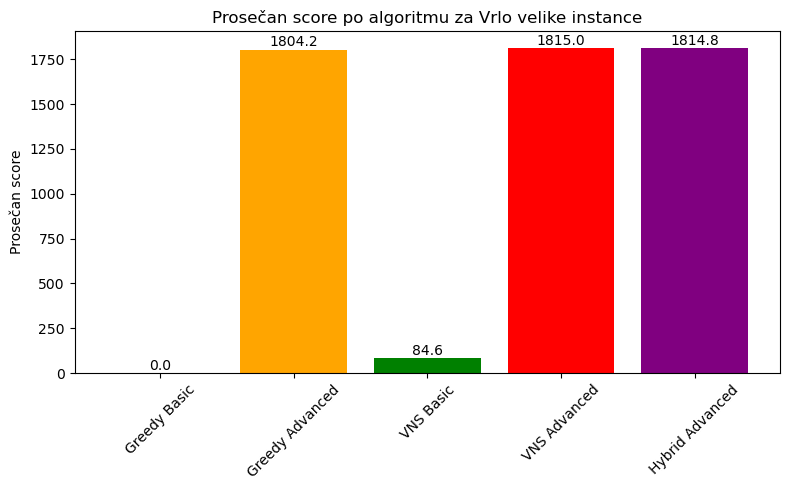

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# Učitaj CSV sa numeričkim score-ovima
df_score = pd.read_csv('results_score.csv')

# Mapiranje veličina i naziva za prikaz
velicine_map = {
    'small': 'Male instance',
    'medium': 'Srednje instance',
    'large': 'Velike instance',
    'xlarge': 'Vrlo velike instance'
}

algoritmi = df_score.columns[1:].tolist()  # preskoči 'Instance'

# Definiši boje za svaki algoritam
boje = ['skyblue', 'orange', 'green', 'red', 'purple']  # po potrebi više
alg_color_map = {alg: boje[i % len(boje)] for i, alg in enumerate(algoritmi)}

# Kreiranje grafika za svaku veličinu
for vel_key, vel_name in velicine_map.items():
    # Filtriraj instanci po veličini
    df_vel = df_score[df_score['Instance'].str.contains(f'instance_{vel_key}_')]
    
    # Izračunaj prosečan score po algoritmu
    avg_scores = df_vel[algoritmi].mean()
    
    # Crtanje stubičastog grafa sa različitim bojama po algoritmu
    plt.figure(figsize=(8,5))
    bars = plt.bar(avg_scores.index, avg_scores.values, color=[alg_color_map[alg] for alg in avg_scores.index])
    
    # Dodavanje numeričkog score-a na vrh svakog bara
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, f'{height:.1f}', ha='center', va='bottom', fontsize=10)
    
    plt.ylabel('Prosečan score')
    plt.title(f'Prosečan score po algoritmu za {vel_name}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



Tabela rezultata po instanci za Male instance:
                                 Instance  Greedy Basic  Greedy Advanced  VNS Basic  VNS Advanced  Hybrid Advanced
              instance_small_10_mixed.txt           0.0             20.5       12.5          24.5             24.5
instance_small_10_multiple_duplicates.txt           0.0             20.5       16.5          20.5             20.5
      instance_small_10_one_duplicate.txt           0.0             16.5       16.5          20.5             20.5
             instance_small_10_random.txt           0.0             12.5       16.5          12.5             12.5
               instance_small_1_mixed.txt           0.0             16.5       20.5          16.5             16.5
 instance_small_1_multiple_duplicates.txt           0.0             20.5       20.5          24.5             24.5
       instance_small_1_one_duplicate.txt           0.0             20.5       16.5          24.5             20.5
              instance_small_1_r

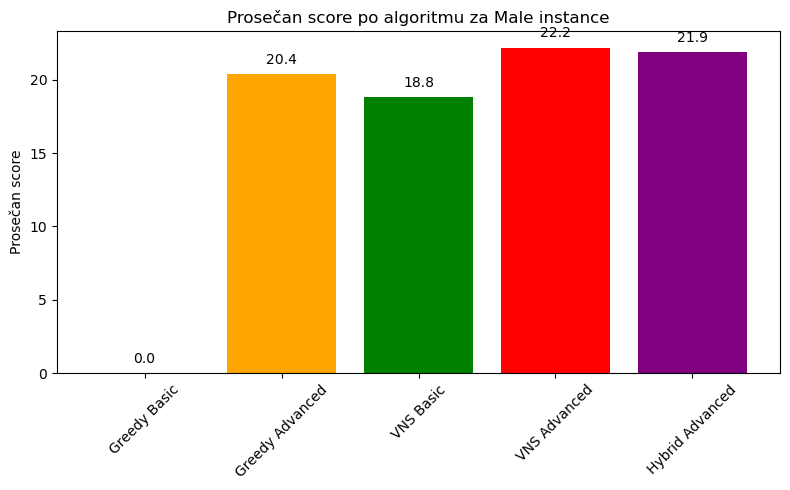

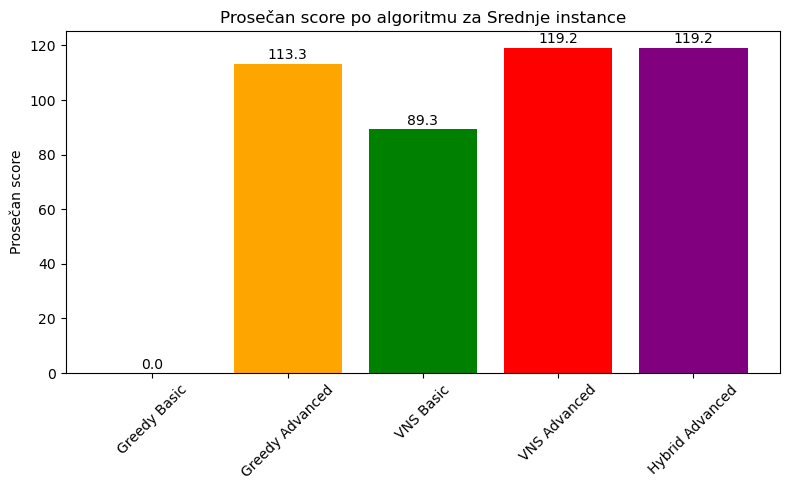

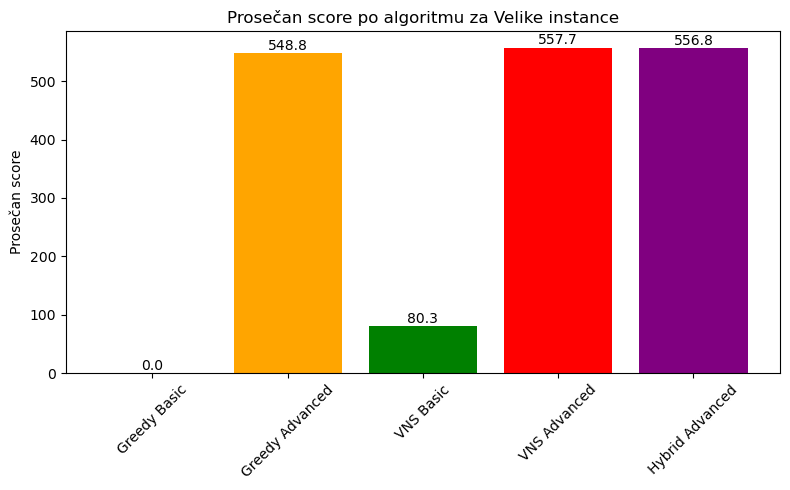

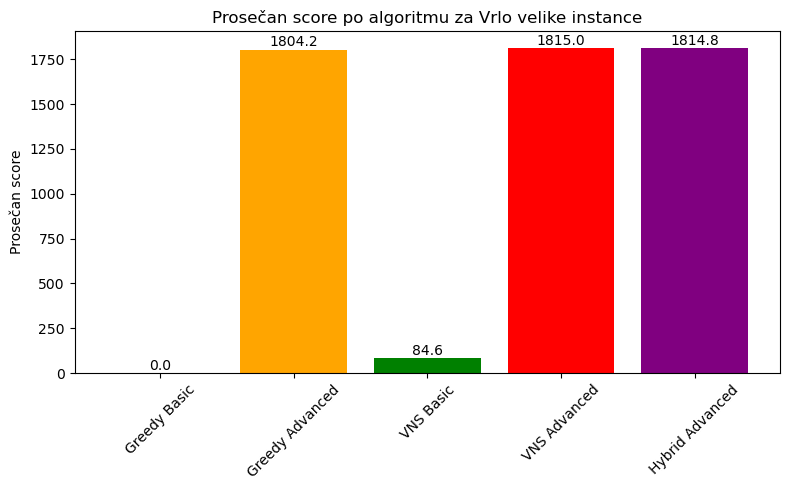

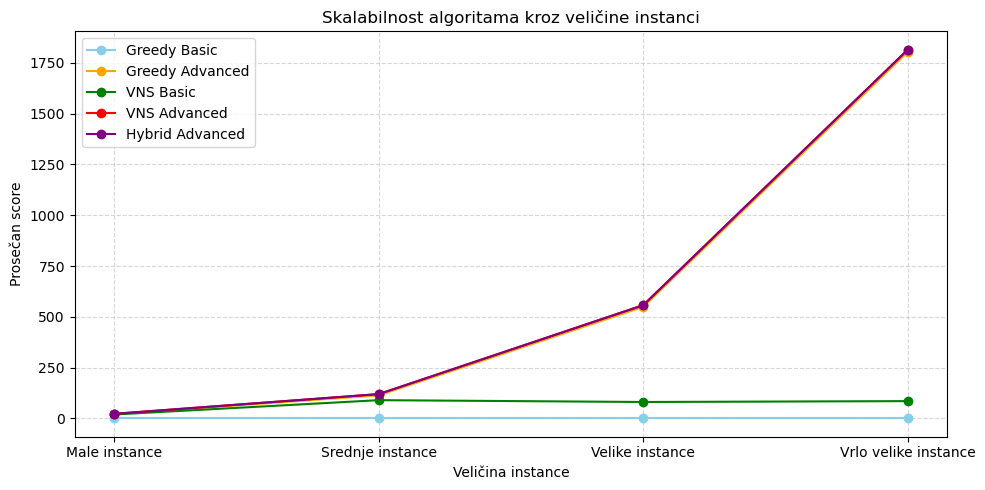

In [54]:
import pandas as pd
import matplotlib.pyplot as plt

# Učitaj CSV sa numeričkim score-ovima
df_score = pd.read_csv('results_score.csv')

# Algoritmi
algoritmi = df_score.columns[1:].tolist()  # preskoči 'Instance'

# Mapiranje veličina i naziva
velicine_map = {
    'small': 'Male instance',
    'medium': 'Srednje instance',
    'large': 'Velike instance',
    'xlarge': 'Vrlo velike instance'
}

# Definiši boje za algoritme
boje = ['skyblue', 'orange', 'green', 'red', 'purple']
alg_color_map = {alg: boje[i % len(boje)] for i, alg in enumerate(algoritmi)}

# ---- 1. Tabele po instanci ----
for vel_key, vel_name in velicine_map.items():
    df_vel = df_score[df_score['Instance'].str.contains(f'instance_{vel_key}_')]
    print(f"\nTabela rezultata po instanci za {vel_name}:")
    print(df_vel.to_string(index=False))

# ---- 2. Prosečan score po grupama (male/srednje/velike/vrlo velike) ----
avg_scores_dict = {}
for vel_key, vel_name in velicine_map.items():
    df_vel = df_score[df_score['Instance'].str.contains(f'instance_{vel_key}_')]
    avg_scores_dict[vel_name] = df_vel[algoritmi].mean()

df_avg = pd.DataFrame(avg_scores_dict, index=algoritmi)

for vel_name in df_avg.columns:
    plt.figure(figsize=(8,5))
    bars = plt.bar(df_avg.index, df_avg[vel_name], color=[alg_color_map[alg] for alg in df_avg.index])
    
    # Dodavanje numeričkog score-a na vrh svakog bara
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, f'{height:.1f}', 
                 ha='center', va='bottom', fontsize=10)
    
    plt.ylabel('Prosečan score')
    plt.title(f'Prosečan score po algoritmu za {vel_name}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# ---- 3. Linijski graf skalabilnosti ----
plt.figure(figsize=(10,5))
for alg in algoritmi:
    plt.plot(df_avg.columns, df_avg.loc[alg], marker='o', label=alg, color=alg_color_map[alg])
    
plt.ylabel('Prosečan score')
plt.xlabel('Veličina instance')
plt.title('Skalabilnost algoritama kroz veličine instanci')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


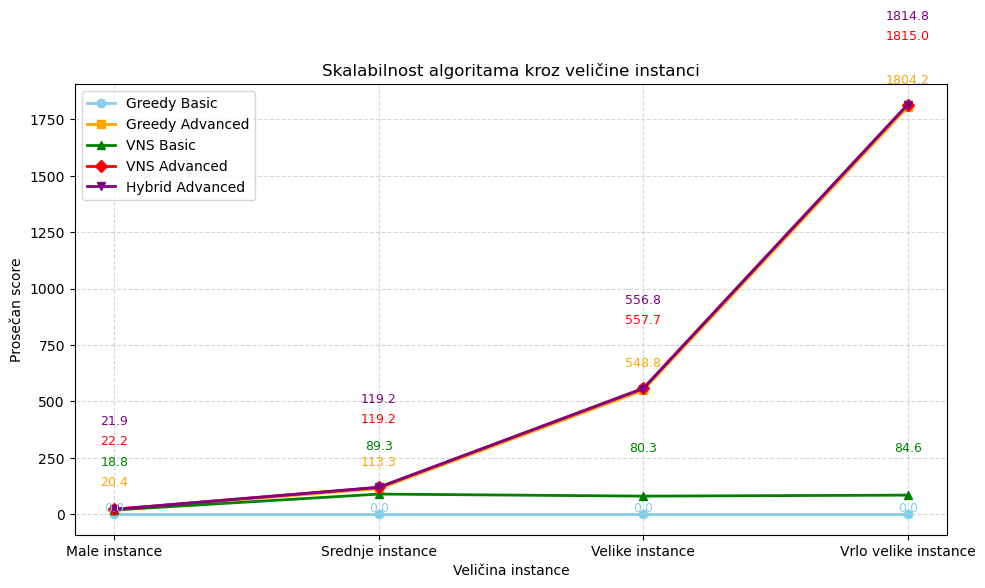

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Učitaj CSV sa numeričkim score-ovima
df_score = pd.read_csv('results_score.csv')

# Algoritmi
algoritmi = df_score.columns[1:].tolist()  # preskoči 'Instance'

# Mapiranje veličina i naziva
velicine_map = {
    'small': 'Male instance',
    'medium': 'Srednje instance',
    'large': 'Velike instance',
    'xlarge': 'Vrlo velike instance'
}

# Boje i markeri
boje = ['skyblue', 'orange', 'green', 'red', 'purple']
markeri = ['o', 's', '^', 'D', 'v']
alg_color_map = {alg: boje[i % len(boje)] for i, alg in enumerate(algoritmi)}
alg_marker_map = {alg: markeri[i % len(markeri)] for i, alg in enumerate(algoritmi)}

# ---- Prosečan score po grupama ----
avg_scores_dict = {}
for vel_key, vel_name in velicine_map.items():
    df_vel = df_score[df_score['Instance'].str.contains(f'instance_{vel_key}_')]
    avg_scores_dict[vel_name] = df_vel[algoritmi].mean()

df_avg = pd.DataFrame(avg_scores_dict, index=algoritmi)

# ---- Linijski graf skalabilnosti sa brojevima iznad linija ----
plt.figure(figsize=(10,6))

# Izračunaj skalirani offset u odnosu na Y-opseg
y_range = df_avg.max().max() - df_avg.min().min()
scale_offset = y_range / 20  # 1/20 opsega

for j, alg in enumerate(algoritmi):
    y_values = df_avg.loc[alg].values
    plt.plot(df_avg.columns, y_values, marker=alg_marker_map[alg], linestyle='-', linewidth=2,
             label=alg, color=alg_color_map[alg])
    
    # Brojevi iznad linije sa skaliranim offset-om
    for i, val in enumerate(y_values):
        vertical_offset = (j * scale_offset) + 0.5  # svaki algoritam malo više
        plt.text(i, val + vertical_offset, f'{val:.1f}', ha='center', va='bottom', 
                 color=alg_color_map[alg], fontsize=9)

plt.ylabel('Prosečan score')
plt.xlabel('Veličina instance')
plt.title('Skalabilnost algoritama kroz veličine instanci')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Definisanje test instance i alfabeta
instances_more = {"test": "ABABABABABAB"}
alphabets_more = {"test": "AB"}

# Lista ograničenja d koje želimo testirati
d_values = [1, 2, 4]  # d, d+1, d+3 u tvom primeru

# Kreiranje praznog DataFrame-a za rezultate
all_results = pd.DataFrame()

# Iteracija kroz sve d vrednosti
for d_val in d_values:
    # Pokretanje algoritama za trenutnu d vrednost
    df_res = compare_algorithms(instances_more, alphabets_more, d=d_val)
    # Dodavanje kolone sa vrednošću d
    df_res['d'] = d_val
    # Dodavanje u ukupne rezultate
    all_results = pd.concat([all_results, df_res], ignore_index=True)

# Prikaz tabele sa svim rezultatima
all_results


,Instance,Greedy Basic,Greedy Advanced,VNS Basic,VNS Advanced,Hybrid Advanced,d
0,test,AB (6),AB (6),AB (6),AB (6),AB (6),1
1,test,ABAB (3),ABAB (3),AB (6),ABAB (3),ABAB (3),2
2,test,,ABABAB (2),ABAB (3),ABABAB (2),ABABAB (2),4
